# Visualizing ICESat-2 land ice products

This notebook demonstrates some basic visualization of ICESat-2 land ice products provided by the ICESat-2 Project Science Office (PSO).

## Learning goals

- Demonstrate basic HDF5 product structures of ICESat-2 standard data products
- Demonstrate the flow of information from the lowest-level products to the highest-level products
- Data search using `earthaccess` and `IS2view`
- File-level data streaming from AWS s3

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import earthaccess
import IS2view
%matplotlib inline

### Authenticate a NASA Earthdata session with `earthaccess`

In [2]:
auth = earthaccess.login()
# attempt to use cloud streaming if in us-west-2
try:
    provider = "NSIDC_CPRD"
    asset = "nsidc-s3"
    fs = earthaccess.get_s3fs_session(provider=provider)
except (AttributeError, NameError) as exc:
    provider = "NSIDC_ECS"
    asset = "nsidc-https"

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/03/2023
Using environment variables for EDL


### ATLAS Background
The primary and secondary instrumentation onboard the ICESat-2 observatory are the Advanced Topographic Laser Altimeter System (ATLAS, a photon-counting laser altimeter), the global positioning system (GPS) and the star cameras. 
Data from these instruments are combined to create three primary measurements: the time of flight of a photon transmitted and received from ATLAS, the position of the satellite in space, and the pointing vector of the satellite during the transmission of photons. 
These three measurements are used to create ATL03, the geolocated photon product of ICESat-2.  

### ATL03 - Global Geolocated Photon Data
- Precise latitude, longitude and elevation for every received photon, arranged by beam in the along-track direction  
- Photons classified by signal vs. background, as well as by surface type (land ice, sea ice, land, ocean), including all geophysical corrections  

More information about ATL03 can be found in the Algorithm Theoretical Basis Documents (ATBDs) provided by the ICESat-2 project:  
- [ATL03: Global Geolocated Photon Data](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl03_atbd_v006.pdf)  
- [ATL03g: Received photon geolocation](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03g_ATBD_r002.pdf)  
- [ATL03a: Atmospheric Delay Corrections](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/I2_ATL03A_ATBD.pdf)  

In [3]:
# parameters for ATL03 Release-06 granule
product = "ATL03"
release = "006"
RGT = 752
granule = 12
cycle = 5
# build a readable granule pattern
pattern = f"{product}_{14 * '?'}_{RGT:04d}{cycle:02d}{granule:02d}_*"
# query CMR for path to ATL03 Release-06 granule
results = earthaccess.search_data(
    short_name = product,
    version = release,
    granule_name = pattern,
    provider = provider
)
# display results
results

Granules found: 1


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L2A Global Geolocated Photon Data V006'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -116.12659, 'Latitude': -49.95483}, {'Longitude': -116.30485, 'Latitude': -49.96598}, {'Longitude': -116.17258, 'Latitude': -50.84003}, {'Longitude': -115.68946, 'Latitude': -53.91168}, {'Longitude': -115.28838, 'Latitude': -56.273}, {'Longitude': -114.85386, 'Latitude': -58.64093}, {'Longitude': -114.4182, 'Latitude': -60.82123}, {'Longitude': -113.96275, 'Latitude': -62.90121}, {'Longitude': -113.79042, 'Latitude': -63.64434}, {'Longitude': -113.5917, 'Latitude': -64.45999}, {'Longitude': -113.37846, 'Latitude': -65.29788}, {'Longitude': -113.17678, 'Latitude': -66.05649}, {'Longitude': -112.98318, 'Latitude': -66.75244}, {'Longitude': -112.28223, 'Latitude': -69.03228}, {'Longitude': -112.01177, 'Latitude': -69.83084}, {'Longitude': -111.71047, 'Latitude': -70.65931}, {'Longitude': -111.

#### ATL03 Background

ATL03 contains most of the data needed to create the higher level data products. 

The structure of the ATL03 HDF5 file has a data group for each beam (`gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, and `gt3r`), data describing the responses of the ATLAS instrument, ancillary data for correcting and transforming the ATL03 data, and a group of metadata.  

ATL03 photon events have a confidence level flag associated with it for a given surface type:  
- -2: possible Transmit Echo Path photons  
- -1: events not associated with a specific surface type  
- 0: noise  
- 1: buffer but algorithm classifies as background  
- 2: low  
- 3: medium  
- 4: high  

In the confidence level matrix, the column of each surface types is:   
- 0: Land  
- 1: Ocean  
- 2: Sea Ice  
- 3: Land Ice  
- 4: Inland Water  

The level of confidence of a given photon event (PE) may vary based on the surface type. There is also now in Release-06 a clustering-based weight from the new "Yet Another Photon Classifier" (YAPC).

The ATLAS instrument decides whether or not to telemeter packets of received photons back as data.  ATLAS uses a digital elevation model (DEM) and a few rules to decide whether to transmit large blocks of data to NASA.  The telemetry bands are evident by the spread of low confidence photon events around the surface for each beam.  

Photon events in ATL03 can come to the ATLAS receiver in a few different ways:  
- Many photons come from the sun either by reflecting off clouds or the land surface.  These photon events are spread in a random distribution along the telemetry band.  In ATL03, a large majority of these "background" photon events are classified, but some may be incorrectly classified as signal.  
- Some photons are from the ATLAS instrument that have reflected off clouds. These photons can be clustered together or widely dispersed depending on the properties of the cloud and a few other variables.  
- Some photons will be returns from the [Transmit Echo Path (TEP)](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl03_known_issues_v006.pdf)  
- Some photons are from the ATLAS instrument that have reflected off the surface (our signal photons).  

#### First Photon Bias (FPB) correction

There will be photons transmitted by the ATLAS instrument will never be recorded back.  The vast majority of these photons never reached the ATLAS instrument again  (only about 10 out of the 10<sup>14</sup> photons transmitted are received), but some are not detected due to the "dead time" of the instrument.  This can create a bias towards the first photons that were received by the instrument.  This first photon bias (FPB) is estimated in the higher level data products.  

#### Transmit Pulse Shape (TPS) correction

The transmitted pulse is also not symmetric in time, which can introduce a bias when calculating average surfaces.  The magnitude of this bias depends on the shape of the transmitted waveform, the width of the window used to calculate the average surface, and the slope and roughness of the surface that broadens the return pulse.  This transmit-pulse shape bias is also estimated in the higher level data products.  

In [4]:
# access or download ATL03 file from NSIDC
if (asset == 'nsidc-s3'):
    fileset = earthaccess.open(results)
elif (asset == 'nsidc-https'):
    fileset = earthaccess.download(results, local_path='.')

# data for beam gtx
gtx = 'gt2r'
# retrieve variables from HDF5 dataset
with h5py.File(fileset[0], mode='r') as fileID:
    # ATL03 Segment ID
    Segment_ID = fileID[gtx]['geolocation']['segment_id'][:]
    # number of photon events
    n_pe, = fileID[gtx]['heights']['delta_time'].shape
    # first photon in the segment (convert to 0-based indexing)
    Segment_Index_begin = fileID[gtx]['geolocation']['ph_index_beg'][:] - 1
    # number of photon events in the segment
    Segment_PE_count = fileID[gtx]['geolocation']['segment_ph_cnt'][:]
    # along-track distance for each ATL03 segment
    Segment_Distance = fileID[gtx]['geolocation']['segment_dist_x'][:]
    # along-track length for each ATL03 segment
    Segment_Length = fileID[gtx]['geolocation']['segment_length'][:]
    # along-track and across-track distance for photon events
    x_atc = fileID[gtx]['heights']['dist_ph_along'][:]
    y_atc = fileID[gtx]['heights']['dist_ph_across'][:]
    # photon event heights
    h_ph = fileID[gtx]['heights']['h_ph'][:]
    # check confidence level associated with each photon event
    # -1: Events not associated with a specific surface type
    #  0: noise
    #  1: buffer but algorithm classifies as background
    #  2: low
    #  3: medium
    #  4: high
    # Signal classification confidence for land ice
    # 0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    ice_sig_conf = fileID[gtx]['heights']['signal_conf_ph'][:,3]
    # YAPC photon event classifier
    weight_ph = fileID[gtx]['heights']['weight_ph'][:]

# for each 20m segment
for j,_ in enumerate(Segment_ID):
    # index for 20m segment j
    idx = Segment_Index_begin[j]
    # skip segments with no photon events
    if (idx < 0):
        continue
    # number of photons in 20m segment
    cnt = Segment_PE_count[j]
    # add segment distance to along-track coordinates
    x_atc[idx:idx+cnt] += Segment_Distance[j]

 Opening 1 granules, approx size: 1.18 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

#### Visualize ATL03 Photon Events

To show the impacts of clouds in more detail, we can investigate the confidence of each photon event for a cloud impacted beam.  For this file, the cloud is situated over the sea surface and does not have an associated confidence for land ice.

This particular set of data approaches the grounding line near Thwaites Glacier in West Antarctica, has some photon events that are impacted by the presence of clouds (highly scattered lower confidence photon events), and has some possible Transmitter Echo Photons (TEP) (the red curved line of anomalous photon events in gt2r and gt3r).  These are [things to be aware of when analyzing photon event data from ATL03](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl03_known_issues_v006.pdf).  

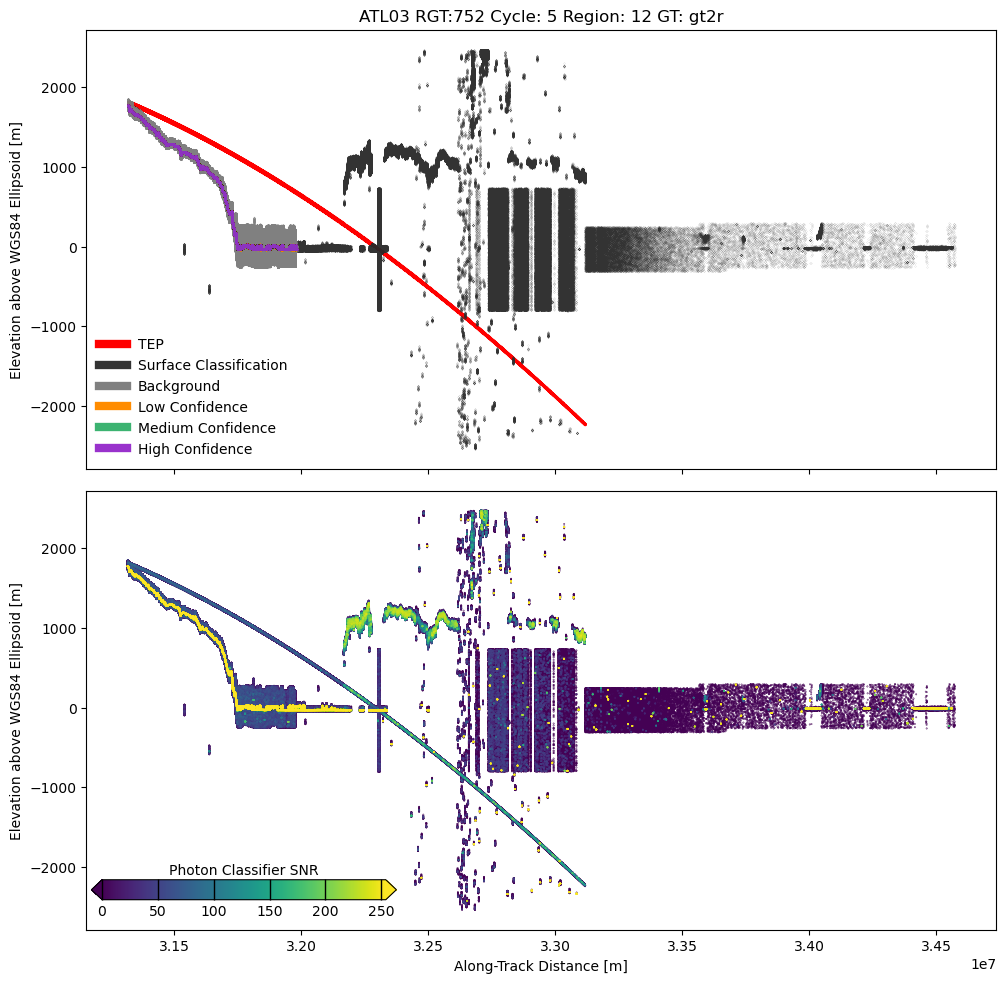

In [5]:
# create scatter plot of photon data versus along-track distance
f1,ax1 = plt.subplots(num=1,nrows=2,sharex=True,sharey=True,figsize=(10,10))

# find possible TEP events
isTEP, = np.nonzero(ice_sig_conf == -2)
# find different surface classification photon events
stype, = np.nonzero(ice_sig_conf == -1)
# background and buffer photons
bg, = np.nonzero((ice_sig_conf == 0) | (ice_sig_conf == 1))
# find photon events of progressively higher confidence
lc, = np.nonzero(ice_sig_conf == 2)
mc, = np.nonzero(ice_sig_conf == 3)
hc, = np.nonzero(ice_sig_conf == 4)

# Photon event geolocation and elevation (WGS84)
ax1[0].plot(x_atc[isTEP], h_ph[isTEP], marker='.',
    markersize=0.1, lw=0, color='red', label='TEP')
ax1[0].plot(x_atc[stype], h_ph[stype], marker='.',
    markersize=0.1, lw=0, color='0.2', label='Surface Classification')
ax1[0].plot(x_atc[bg], h_ph[bg], marker='.',
    markersize=0.1, lw=0, color='0.5', label='Background')
ax1[0].plot(x_atc[lc], h_ph[lc], marker='.',
    markersize=0.1, lw=0, color='darkorange', label='Low Confidence')
ax1[0].plot(x_atc[mc], h_ph[mc], marker='.',
    markersize=0.1, lw=0, color='mediumseagreen', label='Medium Confidence')
ax1[0].plot(x_atc[hc], h_ph[hc], marker='.',
    markersize=0.1, lw=0, color='darkorchid', label='High Confidence')

# sort YAPC weights
isort = np.argsort(weight_ph)
sc = ax1[1].scatter(x_atc[isort], h_ph[isort], c=weight_ph[isort], s=0.1)

# add colorbar for scatter plot
cax = f1.add_axes([0.075, 0.080, 0.305, 0.02])
# add extension triangles to upper and lower bounds
# pad = distance from main plot axis
# shrink = percent size of colorbar
# aspect = lengthXwidth aspect of colorbar
cbar = f1.colorbar(sc, cax=cax, extend='both', extendfrac=0.0375,
    drawedges=False, orientation='horizontal')
# rasterized colorbar to remove lines
cbar.solids.set_rasterized(True)
# Add label to the colorbar
cbar.ax.set_xlabel('Photon Classifier SNR')
cbar.ax.xaxis.set_label_position('top')
# ticks lines all the way across
cbar.ax.tick_params(which='both',width=1,length=15,direction="in")

# set title and labels
ax1[1].set_xlabel('Along-Track Distance [m]')
ax1[0].set_ylabel('Elevation above WGS84 Ellipsoid [m]')
ax1[1].set_ylabel('Elevation above WGS84 Ellipsoid [m]')
title = f'{product} RGT:{RGT} Cycle: {cycle} Region: {granule} GT: {gtx}'
ax1[0].set_title(title)

# create legend
lgd = ax1[0].legend(loc=3,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
    
# adjust the figure axes
f1.subplots_adjust(left=0.07, right=0.98, bottom=0.05, top=0.95, hspace=0.05)
# show the plot
plt.show()

### ATL06 - Land Ice Height Data
- Latitude, longitude and elevation for overlapping 40m along-track segments  
- cm-level corrections for known instrument biases
- Ancillary parameters that can be used to interpret and assess the quality of the height estimates

ATL06 contains most of the data needed to create the Level-3B data products. ATL06 is created by iteratively fitting geolocated photons to a 40-meter line segment. The data is reduced to a window around the expected sloping surface.

Similar to ATL03, the structure of the ATL06 HDF5 file has a data groups for each beam (`gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, and `gt3r`), here with the main variables in the `land_ice_segments` subgroup. ATL06 comes with a quality flag (`atl06_quality_summary`) that identifies segments that are likely valid for ice surfaces.

More information about ATL06 can be found in the [ATBD](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl06_atbd_v006.pdf) provided by NSIDC


In [6]:
# parameters for ATL06 Release-06 granule
product = "ATL06"
release = "006"
RGT = 752
granule = 12
cycle = 5
# build a readable granule pattern
pattern = f"{product}_{14 * '?'}_{RGT:04d}{cycle:02d}{granule:02d}_*"
# query CMR for path to ATL06 Release-06 granule
results = earthaccess.search_data(
    short_name = product,
    version = release,
    granule_name = pattern,
    provider = provider
)
# display results
results

Granules found: 1


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Land Ice Height V006'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -110.1756, 'Latitude': -73.33029}, {'Longitude': -110.57318, 'Latitude': -73.34735}, {'Longitude': -110.47755, 'Latitude': -73.53193}, {'Longitude': -110.13227, 'Latitude': -74.21756}, {'Longitude': -109.70155, 'Latitude': -75.00057}, {'Longitude': -109.2966, 'Latitude': -75.67747}, {'Longitude': -108.85541, 'Latitude': -76.35547}, {'Longitude': -108.37344, 'Latitude': -77.03308}, {'Longitude': -107.93624, 'Latitude': -77.5971}, {'Longitude': -107.36188, 'Latitude': -78.27305}, {'Longitude': -106.83478, 'Latitude': -78.83557}, {'Longitude': -106.61729, 'Latitude': -79.05062}, {'Longitude': -106.02647, 'Latitude': -79.02812}, {'Longitude': -106.25268, 'Latitude': -78.81342}, {'Longitude': -106.80624, 'Latitude': -78.25199}, {'Longitude': -107.40956, 'Latitude': -77.57702}, {'Longitude': -107.86872, 'Latit

In [7]:
# access or download ATL06 file from NSIDC
if (asset == 'nsidc-s3'):
    fileset = earthaccess.open(results)
elif (asset == 'nsidc-https'):
    fileset = earthaccess.download(results, local_path='.')

# data for beam gtx
gtx = 'gt2r'
# retrieve variables from HDF5 dataset
with h5py.File(fileset[0], mode='r') as fileID:
    h5group = fileID[gtx]['land_ice_segments']
    # ATL06 Segment ID
    Segment_ID = h5group['segment_id'][:]
    # number of ATL06 segments
    n_seg, = h5group['delta_time'].shape
    # average transmit time of the segment
    delta_time = h5group['delta_time'][:]
    # along-track and across-track distance 
    x_atc = h5group['ground_track']['x_atc'][:]
    y_atc = h5group['ground_track']['y_atc'][:]
    dh_dx = h5group['fit_statistics']['dh_fit_dx'][:]
    dx = 20.0
    # land ice heights
    h_li = np.ma.array(h5group['h_li'][:],
        fill_value=h5group['h_li'].attrs['_FillValue'])
    h_li.mask = (h_li.data == h_li.fill_value)
    # segment quality summary flag
    atl06_quality_summary = h5group['atl06_quality_summary'][:]

 Opening 1 granules, approx size: 0.03 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

#### Visualize ATL06 Segments

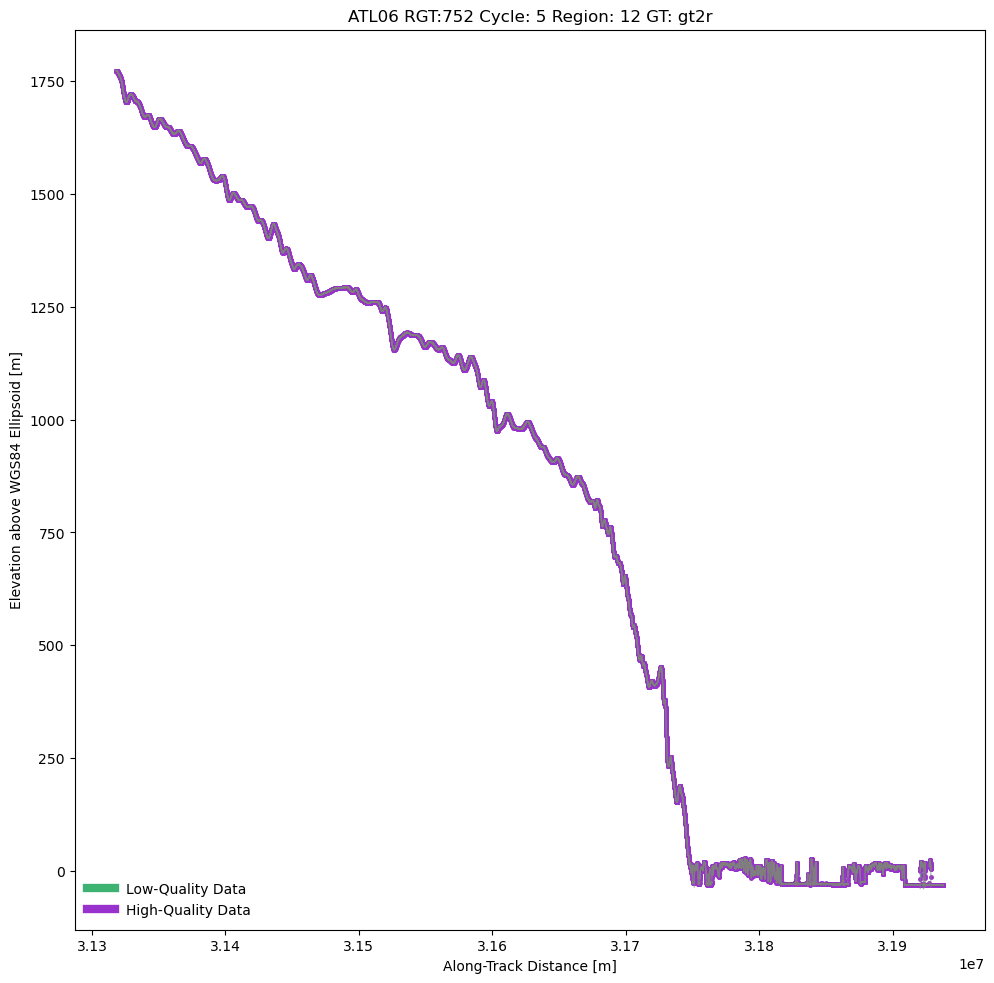

In [8]:
# create scatter plot of segment data versus along-track distance
f2,ax2 = plt.subplots(num=2, figsize=(10,10))

# find low and high quality data
lq, = np.nonzero(atl06_quality_summary != 0)
hq, = np.nonzero(atl06_quality_summary == 0)

# segment geolocation and elevation (WGS84)
ax2.plot(x_atc[lq], h_li[lq], marker='.',
    markersize=5, lw=0, color='mediumseagreen', label='Low-Quality Data')
ax2.plot(x_atc[hq], h_li[hq], marker='.',
    ms=5, lw=0, color='darkorchid', label='High-Quality Data')
distances = np.c_[x_atc[hq] - dx, x_atc[hq] + dx]
heights = np.c_[h_li[hq] - dx*dh_dx[hq], h_li[hq] + dx*dh_dx[hq]]
ax2.plot(distances.T, heights.T, color='0.5', alpha=0.5, lw=1)

# set title and labels
ax2.set_xlabel('Along-Track Distance [m]')
ax2.set_ylabel('Elevation above WGS84 Ellipsoid [m]')
title = f'{product} RGT:{RGT} Cycle: {cycle} Region: {granule} GT: {gtx}'
ax2.set_title(title)
# create legend
lgd = ax2.legend(loc=3,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
    
# adjust the figure axes
f2.subplots_adjust(left=0.07, right=0.98, bottom=0.05, top=0.95)
# show the plot
plt.show()

### ATL11 - Slope-Corrected Land Ice Height Time Series Data
- Latitude, longitude and elevation for 120m along-track segments  

ATL11 contains most of the data needed to create the Level-3B gridded land ice products. To make ATL11, ATL06 data is combined from the two beams in a pair to create a single pair track solution, which is corrected for across-track slope. 

The structure of the ATL11 HDF5 file has a data groups for each beam pair (`pt1`, `pt2`, and `pt3`). ATL11 also comes with a quality flag (`quality_summary`) that identifies segments that are likely valid for ice surfaces. All cycles of data are provided within the ATL11 file, which simplifies the calculation of elevation change as a function of time.


More information about ATL11 can be found in the [ATBD](https://nsidc.org/sites/default/files/icesat2_atl11_atbd_r005_0.pdf) provided by NSIDC

In [9]:
# parameters for ATL11 Release-05 granule
product = "ATL11"
release = "005"
RGT = 752
granule = 12
# build a readable granule pattern for ATL11
pattern = f"{product}_{RGT:04d}{granule:02d}_*"
# query CMR for path to ATL11 Release-05 granule
results = earthaccess.search_data(
    short_name = product,
    version = release,
    granule_name = pattern,
    provider = provider
)
# display results
results

Granules found: 1


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V005'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -110.47869, 'Latitude': -73.09375}, {'Longitude': -110.62383, 'Latitude': -73.10645}, {'Longitude': -110.6692, 'Latitude': -73.13345}, {'Longitude': -109.02027, 'Latitude': -76.10471}, {'Longitude': -106.65736, 'Latitude': -79.01101}, {'Longitude': -106.54484, 'Latitude': -79.03259}, {'Longitude': -106.26147, 'Latitude': -79.01883}, {'Longitude': -106.17867, 'Latitude': -79.02088}, {'Longitude': -106.08759, 'Latitude': -79.00916}, {'Longitude': -106.0668, 'Latitude': -78.98859}, {'Longitude': -108.1715, 'Latitude': -76.61328}, {'Longitude': -110.32642, 'Latitude': -73.02071}, {'Longitude': -110.39481, 'Latitude': -72.9983}, {'Longitude': -110.46485, 'Latitude': -73.00115}, {'Longitude': -110.50758, 'Latitude': -73.01765}, {'Longitude': -110.47869, 'Latitude': -73.09375}]}}]}}}

In [10]:
# access or download ATL11 file from NSIDC
if (asset == 'nsidc-s3'):
    fileset = earthaccess.open(results)
elif (asset == 'nsidc-https'):
    fileset = earthaccess.download(results, local_path='.')

# data for beam pair ptx
ptx = 'pt2'
# retrieve variables from HDF5 dataset
with h5py.File(fileset[0], mode='r') as fileID:
    # ATL11 reference point
    Segment_ID = fileID[ptx]['ref_pt'][:]
    # number of ATL11 segments
    n_seg,n_cycles = fileID[ptx]['delta_time'].shape
    # average transmit time of the segment
    delta_time = fileID[ptx]['delta_time'][:]
    # orbital cycle number
    cycle_number = fileID[ptx]['cycle_number'][:]
    # longitude and latitude
    longitude = fileID[ptx]['longitude'][:]
    latitude = fileID[ptx]['latitude'][:]
    # along-track and across-track distance
    x_atc = fileID[ptx]['cycle_stats']['x_atc'][:]
    y_atc = fileID[ptx]['cycle_stats']['y_atc'][:]
    # slope corrected land ice heights
    h_corr = np.ma.array(fileID[ptx]['h_corr'][:],
        fill_value=fileID[ptx]['h_corr'].attrs['_FillValue'])
    h_corr.mask = (h_corr.data == h_corr.fill_value)
    # only include high-quality segments
    h_corr.mask |= (fileID[ptx]['quality_summary'][:] != 0)

 Opening 1 granules, approx size: 0.02 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

#### Visualize ATL11 segments

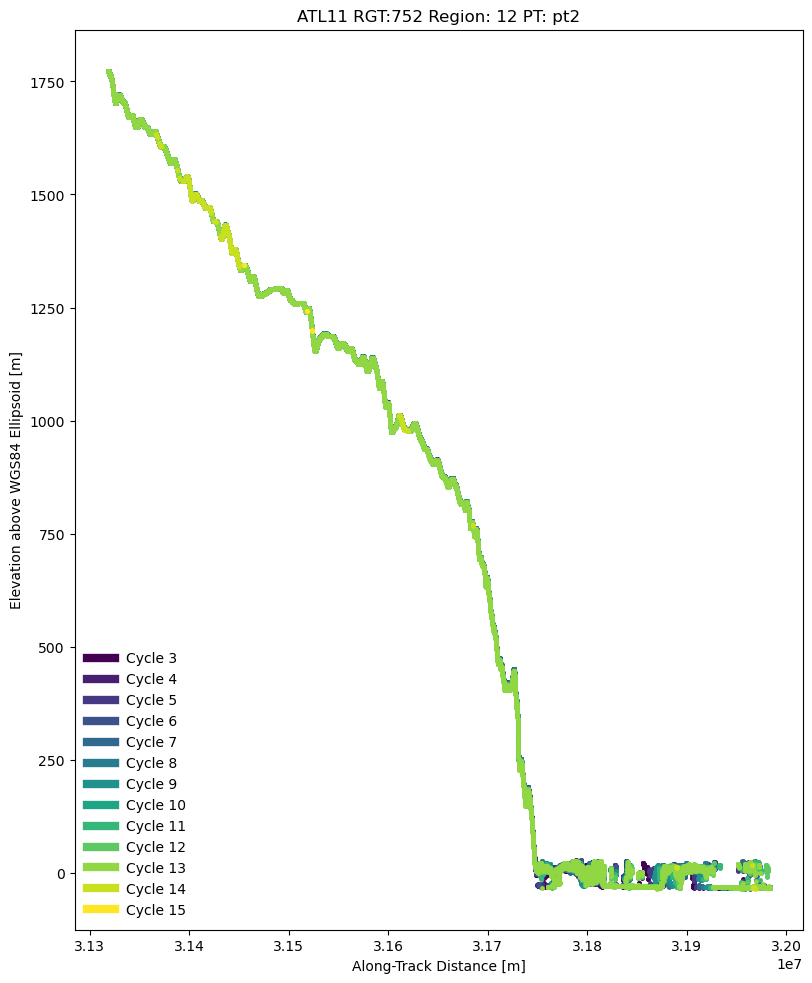

In [11]:
# create scatter plot of segment data versus along-track distance
f3,ax3 = plt.subplots(num=3, figsize=(8,10))

# segment geolocation and elevation for each cycle
colors = plt.cm.viridis(np.linspace(0,1,n_cycles))
for i,c in enumerate(cycle_number):
    ax3.plot(x_atc[:,i], h_corr[:,i], marker='.',
        ms=5, lw=0, color=colors[i], label=f'Cycle {c:d}')

# set title and labels
ax3.set_xlabel('Along-Track Distance [m]')
ax3.set_ylabel('Elevation above WGS84 Ellipsoid [m]')
title = f'{product} RGT:{RGT} Region: {granule} PT: {ptx}'
ax3.set_title(title)
# create legend
lgd = ax3.legend(loc=3, frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)

# adjust the figure axes
f3.subplots_adjust(left=0.07, right=0.98, bottom=0.05, top=0.95)
# show the plot
plt.show()

### ATL15 - Gridded Land Ice Height Change Data
- Time-variable land ice height change and change rate at 1km, 10km, 20km and 40km spatial resolutions
- Relative elevation provided at quarter-annual time resolution
- Height change rate at quarter-annual, annual and multi-annual time resolutions

All ATL11 along-track data is combined in a constrained least-squares solution to provided gridded fields that are smoothly interpolated between tracks. The solution provides the reference elevation at a time point (ATL14) and the relative elevation change at the quarter-annual time points (ATL15).

More information about ATL14 and ATL15 can be found in the [ATBD](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl14_atl15_atbd_r002.pdf) provided by NSIDC

In [12]:
# query CMR for path to ATL15 Release-02 granule
granule = IS2view.utilities.query_resources(product='ATL15',
    release='002', regions='AA', resolutions='01km', asset='nsidc-https')
# read ATL15 granule
ds = IS2view.io.from_file(granule, group='delta_h', format='nc')
ds

<xarray.Dataset>
Dimensions:              (time: 15, x: 5461, y: 4461)
Coordinates:
  * time                 (time) float64 273.9 365.2 ... 1.461e+03 1.552e+03
  * x                    (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y                    (y) float64 2.27e+06 2.269e+06 ... -2.189e+06 -2.19e+06
    Polar_Stereographic  int64 0
Data variables:
    ice_area             (time, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/117)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             94150869.62631059
    time_coverage_end:                  2022-03-23T03:19:26.843657Z
    time_coverage_start:                2019-03-29T10:18:17.217346Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

#### Create an along-track plot interpolating ATL15 to ATL11 geolocations

Examples of using `IS2view` can be found in the [Documentation Recipes](https://is2view.readthedocs.io/en/latest/user_guide/Recipes.html)

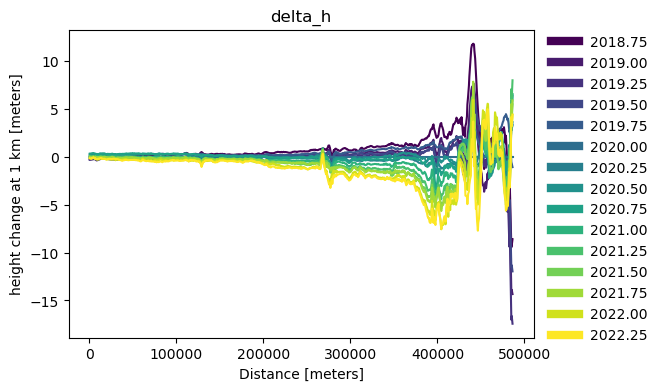

In [13]:
# create geoJSON-like data from ATL11 coordinates
geometry = dict(type='LineString', coordinates=list(zip(longitude, latitude)))
feature = dict(type='Feature', id=0, geometry=geometry)
# plot ATL15 relative heights (in reference to 2020.0) along the ATL11 line
ds.timeseries.plot(feature, variable='delta_h', cmap=plt.cm.viridis, legend=True)